# Import libraries

In [1]:
import numpy as np
from scipy.spatial import KDTree
import os
import h5py
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Set file paths

In [2]:
# Load TAHMO station data (CSV format with columns:'precipitation')
gmet_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\GMET\GMet_AWSdata\GMet_AWSdata'
imerg_root_dir = r'D:\Ghana\IMERG_data\GPM\NRT\IMERG\IMERG-ER'

# Set threshold list to analyse

In [3]:
thresholds_list = [0.6, 1.7, 2.7, 5, 8.6, 15]

# Import GMET stationsdata

In [5]:
station_data_list_GMET = []
station_name_list_files = []
for station in os.listdir(gmet_root_dir):
    if station.endswith('.csv'):
        station_file = os.path.join(gmet_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_data_list_GMET.append(station_data)
        station_name_list_files.append(station.split('.')[0])
        #display(station_data)

stations_meta_data_GMET = station_data_list_GMET.pop(7)
station_name_list = stations_meta_data_GMET['STN'].tolist()

station_data_gmet_dict = dict(zip(station_name_list, station_data_list_GMET))

for station_name in station_data_gmet_dict:
    # Convert 'timestamp' column to datetime format
    station_data_gmet_dict[station_name]['Timestamp'] = pd.to_datetime(
        station_data_gmet_dict[station_name]['Date'].astype(str) + ' ' + 
        station_data_gmet_dict[station_name]['Time'].astype(str),
        format='%m/%d/%Y %I:%M:%S %p'
    )
    # Set Timestamp as the index
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].set_index('Timestamp')
    # Drop the original Date and Time columns
    station_data_gmet_dict[station_name] = station_data_gmet_dict[station_name].drop(['Date', 'Time'], axis=1)

    # Ensure the column is numeric
    for col in station_data_gmet_dict[station_name].columns:
        station_data_gmet_dict[station_name][col] = pd.to_numeric(station_data_gmet_dict[station_name][col], errors='coerce')




In [6]:
# Traverse through all subdirectories and files in the given path
imerg_files_path = []
for root, dirs, files in os.walk(imerg_root_dir):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path.append(os.path.join(root, file))

# Get the longitude latitude grid

In [7]:
# Load the SEVIRI file to get longitude latitude grid
file_name = '3B-HHR.MS.MRG.3IMERG.20200101-S013000-E015959.0090.V07B.HDF5'
file_path = fr'D:\Ghana\IMERG_data\GPM\RS\V07\IMERG\IMERG-FR\2020\01\01\{file_name}'

with h5py.File(file_path, 'r') as imerg_ds:
# imerg_ds = xr.open_dataset(file_path) #, engine = 'netcdf4')

     # List the top-level keys (you already found 'grid')
    print("Top-level keys:", list(imerg_ds.keys()))
    print('Down-level keys:', list(imerg_ds['Grid'].keys()))

    grid_lat = imerg_ds['Grid/lat'][:]
    grid_lon = imerg_ds['Grid/lon'][:]
    #print(grid_lat)
    
    # Access the 'grid' group
    precip = imerg_ds['Grid/precipitation'][:]
    print(precip)

    
# Create 2D latitude and longitude grids
grid_lon_2d, grid_lat_2d = np.meshgrid(grid_lon, grid_lat)

print(len(grid_lat))
print(len(grid_lon))

grid_lat_2d = np.flipud(grid_lat_2d)

Top-level keys: ['Grid']
Down-level keys: ['Intermediate', 'nv', 'lonv', 'latv', 'time', 'lon', 'lat', 'time_bnds', 'lon_bnds', 'lat_bnds', 'precipitation', 'randomError', 'probabilityLiquidPrecipitation', 'precipitationQualityIndex']
[[[-9999.9 -9999.9 -9999.9 ...     0.      0.      0. ]
  [-9999.9 -9999.9 -9999.9 ...     0.      0.      0. ]
  [-9999.9 -9999.9 -9999.9 ...     0.      0.      0. ]
  ...
  [-9999.9 -9999.9 -9999.9 ...     0.      0.      0. ]
  [-9999.9 -9999.9 -9999.9 ...     0.      0.      0. ]
  [-9999.9 -9999.9 -9999.9 ...     0.      0.      0. ]]]
1800
3600


# Define function to find nearest grid to stations

In [8]:
def nearest_grid_to_stations(grid_lat, grid_lon, station_lat, station_lon):
    """
    Map stations to nearest grid cells using KDTree.
    
    Parameters
    ----------
    grid_lat : numpy.ndarray
        Latitudes of grid cells.
    grid_lon : numpy.ndarray
        Longitudes of grid cells.
    station_lat : numpy.ndarray
        Latitudes of stations.
    station_lon : numpy.ndarray
        Longitudes of stations.
    
    Returns
    -------
    indices : numpy.ndarray
        Indices of grid cells nearest to each station.
    """
    grid_points = np.array(list(zip(grid_lat.ravel(), grid_lon.ravel())))
    station_points = np.array(list(zip(station_lat, station_lon)))
    tree = KDTree(grid_points)
    _, indices = tree.query(station_points)
    return indices

In [9]:
indices = nearest_grid_to_stations(grid_lat_2d, grid_lon_2d, stations_meta_data_GMET['LAT'], stations_meta_data_GMET['LON'])
print(indices)

[3000592 3029406 3025790 3015000 3022201 3065377 3029371 2860172 2852991
 2935799 2870991 2892599 3014976 3047380 3036600 2950189 2878174 2899799]


In [10]:
precip_station_cells = np.zeros(( len(imerg_files_path), len(station_name_list)))
dt_list = np.empty(len(imerg_files_path), dtype = object)

for i, file in enumerate(imerg_files_path):
    try:
        date_str = os.path.basename(file).split('.')[4].split('-')[0]
        time_str = os.path.basename(file).split('.')[4].split('-')[2][1:7]
        dt = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S") + timedelta(seconds = 1)
        dt_list[i] = dt
        with h5py.File(file, 'r') as f:
            # convert from mm/h to mm/30 min
            precip = f['Grid/precipitationCal'][:] / 2
    
                        # # Flip the data along the y-axis
            # target = np.flipud(target)
            # pred = np.flipud(pred)  
    
            # Reducing the time dimension as it is 1
            precip = np.flipud(np.squeeze(precip.T))
    
      
            for j, grid_idx in enumerate(indices):
                precip_station_cells[i, j] = precip.flat[grid_idx]

    except:
        print('Error occured')
        for j, grid_idx in enumerate(indices):
            precip_station_cells[i, j] = np.nan

Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error 

In [11]:
print(len(dt_list))
print(len(precip_station_cells))

datetime_index = pd.DatetimeIndex(dt_list)
df_precip = pd.DataFrame(precip_station_cells, index=datetime_index, columns = station_name_list)
df_precip = df_precip[~df_precip.index.duplicated()]

df_precip.to_csv(f'imerg_early_precip.csv')
display(df_precip)

68064
68064


,Abetifi,Ada_Foah,Akim_Oda,Akosombo,Akuse,Axim,Enchi,Jirapa,Kalbeo,Kpandai,Loagri,Nakpamboni,Sefwi_Bekwai,Tarkwa,Tema,Tolon,Varenpare,Yendi
2020-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
for station_name in station_data_gmet_dict:   
    df = pd.concat([df_precip[station_name], station_data_gmet_dict[station_name]], join = 'inner', axis = 1)

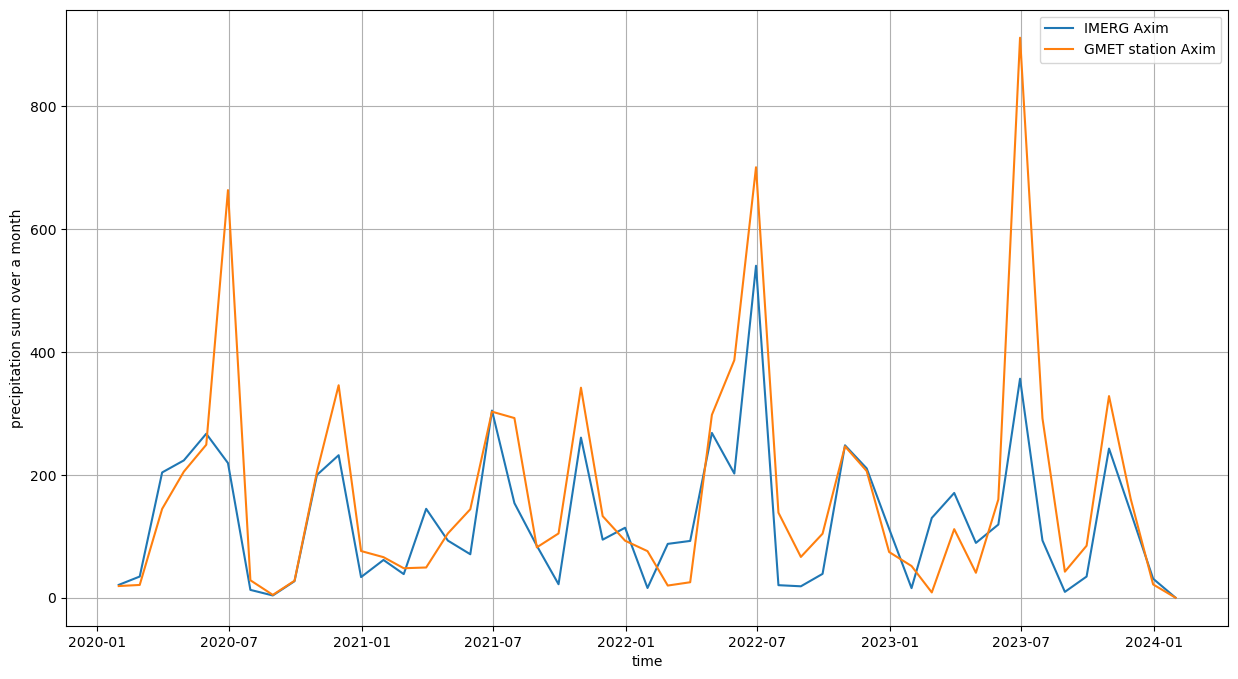

In [13]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'Axim'

df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum()

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'GMET station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.grid()

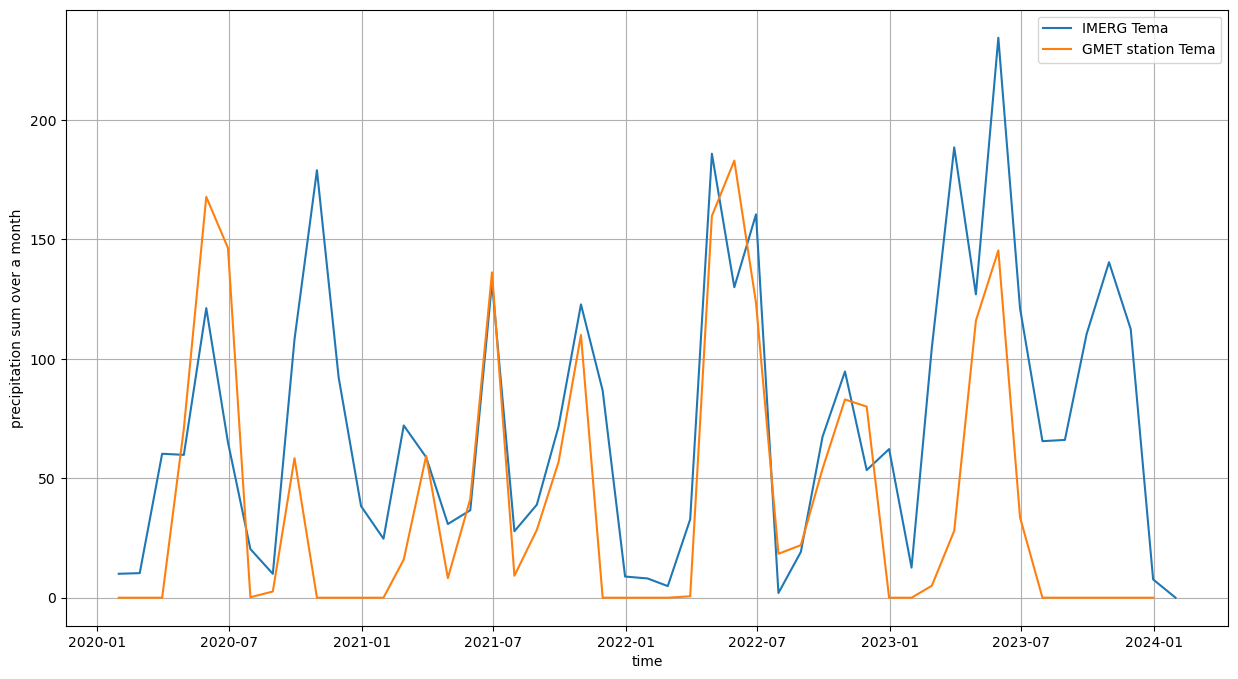

In [14]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'Tema'

df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum()

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'GMET station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.grid()

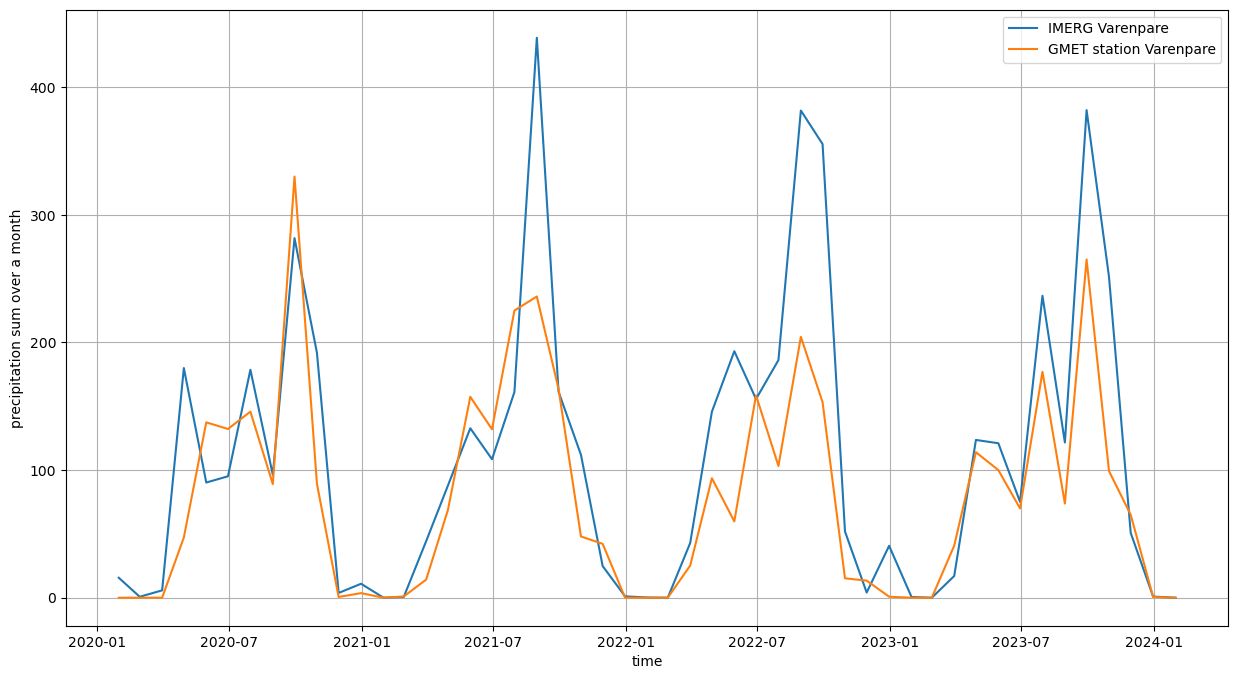

In [15]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'Varenpare'

df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum()

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'GMET station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.grid()

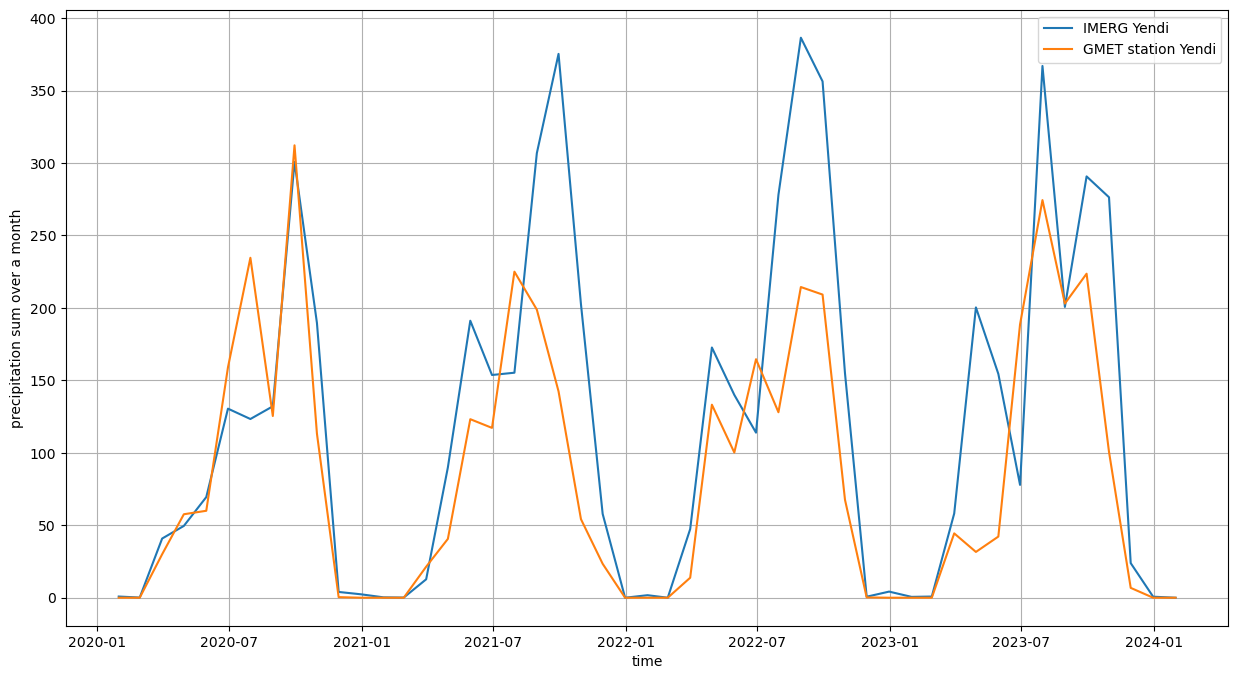

In [16]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'Yendi'

df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum()

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'GMET station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.grid()

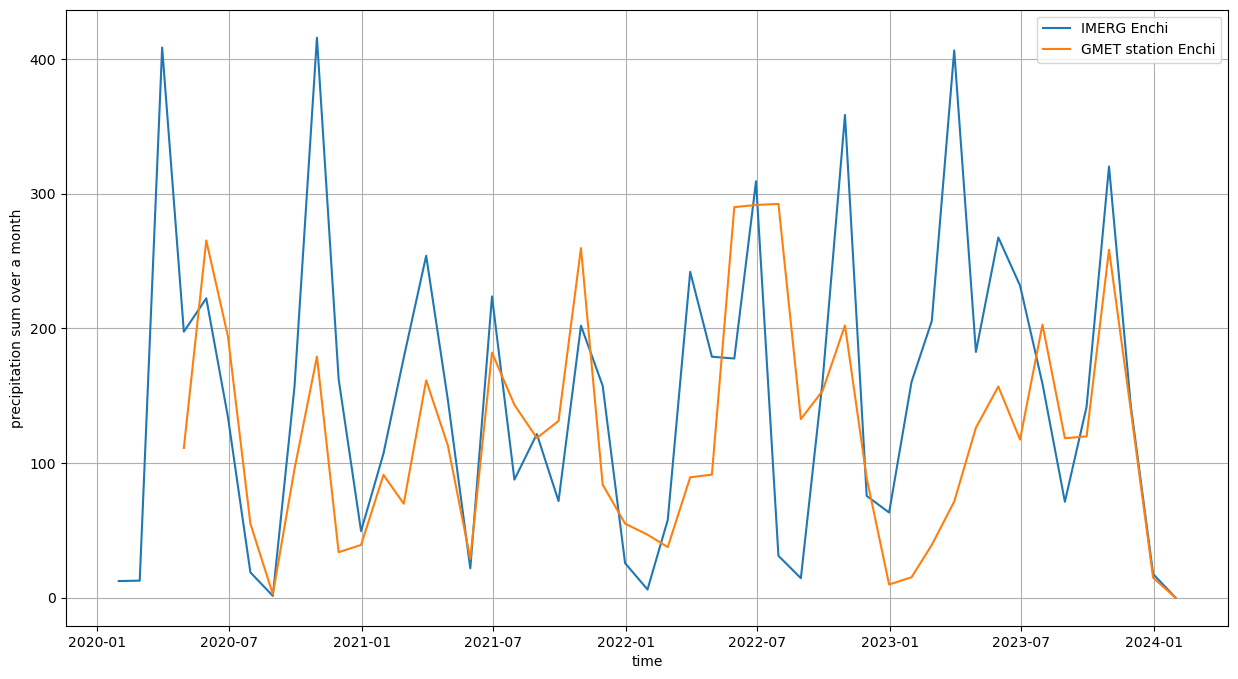

In [17]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'Enchi'

df_gmet = station_data_gmet_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum()

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'GMET station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.grid()